# 03 — Baseline Forecasting Models

Goal:
Establish benchmark forecasting models for winter temperature prediction.

We implement:
1) Naive forecast
2) Rolling mean forecast
3) Lag-based Linear Regression

Evaluation metric: RMSE
Validation strategy: chronological split (no data leakage)

## 1. Imports and plotting configuration

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_style("whitegrid")

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "legend.fontsize": 10,
})

## 2. Load processed winter dataset

We use the cleaned and merged dataset from the processed directory.

In [77]:
df = pd.read_csv("../data/processed/winter_2021_2026.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")
df = df.set_index("date")

df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,season,temp_range
date,,,,,,,,,,,,
2021-12-01,3.3,-0.5,10.2,NaN,1.0,NaN,7.2,NaN,1020.8,NaN,2021–2022,10.7
2021-12-02,5.4,1.7,11.5,NaN,1.0,NaN,7.3,NaN,1017.8,NaN,2021–2022,9.8
2021-12-03,7.1,1.0,12.7,NaN,NaN,NaN,7.8,NaN,1018.7,NaN,2021–2022,11.7
2021-12-04,4.8,0.0,8.6,NaN,NaN,NaN,7.2,NaN,1023.5,NaN,2021–2022,8.6
2021-12-05,3.1,-0.2,5.4,NaN,NaN,NaN,6.6,NaN,1018.8,NaN,2021–2022,5.6


## 3. Train-test split (chronological)

The last winter season is used as test data.
No random splitting is applied to avoid data leakage.

In [78]:
train = df.iloc[:-90]
test = df.iloc[-90:]

y_train = train["tavg"]
y_test = test["tavg"]

## 4. Baseline 1 — Naive Forecast

Assumption:
The next day's temperature equals the last observed value.

In [79]:
df = df.dropna(subset=["tavg"])

train = df.iloc[:-90]
test = df.iloc[-90:]

y_train = train["tavg"]
y_test = test["tavg"]

last_value = float(y_train.iloc[-1])
y_pred_naive = np.full(len(y_test), last_value)

rmse_naive = np.sqrt(mean_squared_error(y_test.values, y_pred_naive))
rmse_naive


np.float64(4.992015847553193)

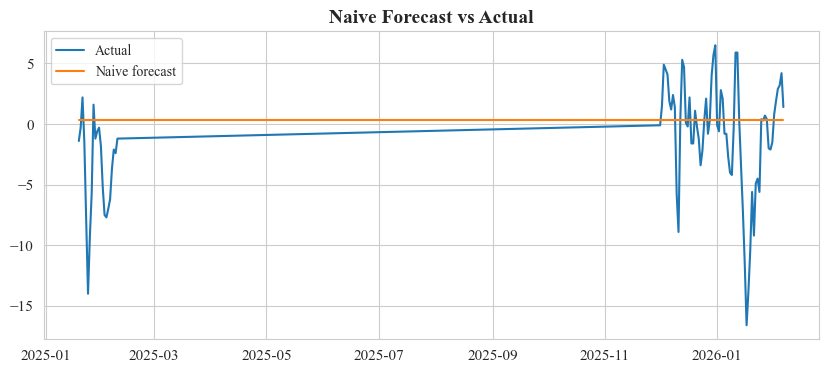

In [80]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_naive, label="Naive forecast")
plt.title("Naive Forecast vs Actual")
plt.legend()
plt.show()  

## 5. Baseline 2 — Rolling Mean

Forecast is defined as the mean temperature of the last 7 days.

In [81]:
window = 7

rolling_mean = y_train.rolling(window=window).mean().iloc[-1]
y_pred_roll = np.repeat(rolling_mean, len(y_test))

rmse_roll = np.sqrt(mean_squared_error(y_test, y_pred_roll))
rmse_roll

np.float64(4.705292046476009)

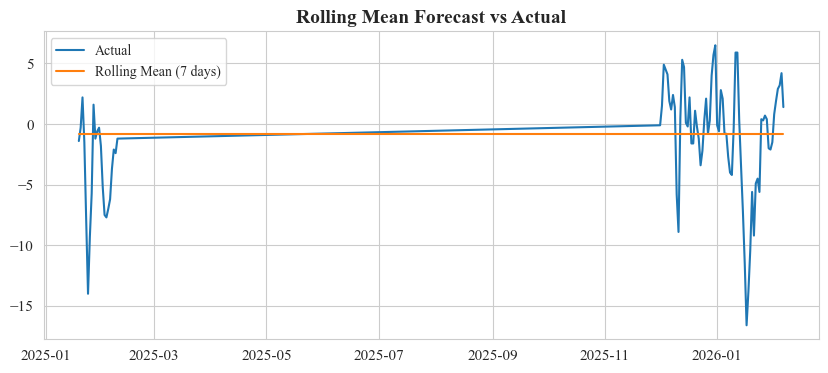

In [82]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_roll, label="Rolling Mean (7 days)")
plt.title("Rolling Mean Forecast vs Actual")
plt.legend()
plt.show()

## 6. Lag-based Linear Regression

We construct autoregressive features:

Temperature(t-1), Temperature(t-2), Temperature(t-3)

In [83]:
df_model = df.copy()

df_model["tavg"] = pd.to_numeric(df_model["tavg"], errors="coerce")

for lag in [1,2,3]:
    df_model[f"lag_{lag}"] = df_model["tavg"].shift(lag)

df_model = df_model.dropna(subset=["tavg", "lag_1", "lag_2", "lag_3"])

print("Rows after cleaning:", len(df_model))


Rows after cleaning: 349


In [84]:


split_idx = int(len(df_model) * 0.8)

train = df_model.iloc[:split_idx]
test = df_model.iloc[split_idx:]

X_train = train[["lag_1", "lag_2", "lag_3"]]
X_test = test[["lag_1", "lag_2", "lag_3"]]

y_train = train["tavg"]
y_test = test["tavg"]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_lr


np.float64(2.737467316584391)

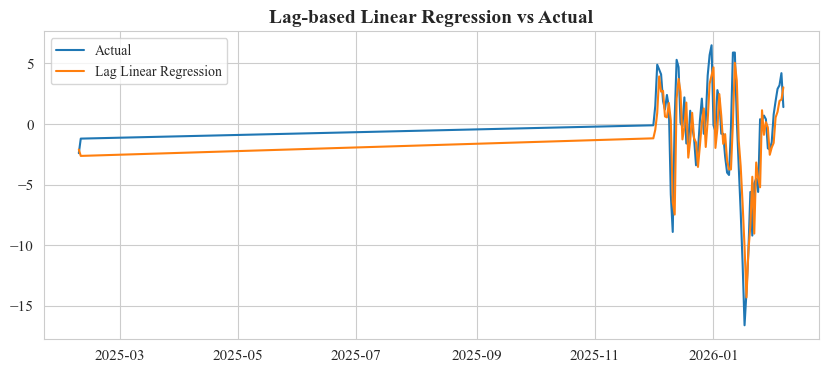

In [85]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lr, label="Lag Linear Regression")
plt.title("Lag-based Linear Regression vs Actual")
plt.legend()
plt.show()  

## 7. Model comparison (RMSE)

Lower RMSE indicates better predictive accuracy.

In [86]:
results = pd.DataFrame({
    "Model": ["Naive", "Rolling Mean", "Lag Linear Regression"],
    "RMSE": [rmse_naive, rmse_roll, rmse_lr]
})

results.sort_values("RMSE")

,Model,RMSE
2,Lag Linear Regression,2.737467
1,Rolling Mean,4.705292
0,Naive,4.992016


## 8. Conclusions

- The naive model serves as a minimum benchmark.
- Rolling mean smooths noise but may underreact to sudden changes.
- Lag-based regression captures short-term temporal dependence.

These baselines provide a reference point for more advanced models.